<a href="https://colab.research.google.com/github/wel51x/DS-Unit-2-Sprint-4-Model-Validation/blob/master/DS_Unit_2_Sprint_Challenge_4_Model_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Data Science Unit 2 Sprint Challenge 4 — Model Validation

Follow the instructions for each numbered part to earn a score of 2. See the bottom of the notebook for a list of ways you can earn a score of 3.

## Predicting Blood Donations

Our dataset is from a mobile blood donation vehicle in Taiwan. The Blood Transfusion Service Center drives to different universities and collects blood as part of a blood drive.

The goal is to predict the last column, whether the donor made a donation in March 2007, using information about each donor's history. We'll measure success using recall score as the model evaluation metric.

Good data-driven systems for tracking and predicting donations and supply needs can improve the entire supply chain, making sure that more patients get the blood transfusions they need.

#### Run this cell to load the data:

In [0]:
import pandas as pd
import numpy as np
import warnings

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', None) # all cols
pd.set_option('display.width', 161)
warnings.filterwarnings('ignore')


In [0]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/blood-transfusion/transfusion.data')

df = df.rename(columns={
    'Recency (months)': 'months_since_last_donation', 
    'Frequency (times)': 'number_of_donations', 
    'Monetary (c.c. blood)': 'total_volume_donated', 
    'Time (months)': 'months_since_first_donation', 
    'whether he/she donated blood in March 2007': 'made_donation_in_march_2007'
})

In [4]:
df.sample(8)

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
47,2,2,500,2,0
284,11,5,1250,33,0
523,1,10,2500,43,1
277,4,3,750,34,0
285,11,2,500,14,0
440,16,3,750,46,0
556,5,6,1500,28,0
226,4,1,250,4,0


In [5]:
df.describe()

,months_since_last_donation,number_of_donations,total_volume_donated,months_since_first_donation,made_donation_in_march_2007
count,748.000000,748.000000,748.000000,748.000000,748.000000
mean,9.506684,5.514706,1378.676471,34.282086,0.237968
std,8.095396,5.839307,1459.826781,24.376714,0.426124
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.750000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,50.000000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
months_since_last_donation     748 non-null int64
number_of_donations            748 non-null int64
total_volume_donated           748 non-null int64
months_since_first_donation    748 non-null int64
made_donation_in_march_2007    748 non-null int64
dtypes: int64(5)
memory usage: 29.3 KB


In [7]:
df["made_donation_in_march_2007"].value_counts(normalize=True)

0    0.762032
1    0.237968
Name: made_donation_in_march_2007, dtype: float64

## Part 1.1 — Begin with baselines

What **accuracy score** would you get here with a **"majority class baseline"?** 
 
(You don't need to split the data into train and test sets yet. You can answer this question either with a scikit-learn function or with a pandas function.)

In [0]:
X = df.drop(columns = 'made_donation_in_march_2007')
y = df['made_donation_in_march_2007']

In [0]:
majority_class = 0
y_pred = [majority_class] * len(y)

In [10]:
print("Accuracy Score:", accuracy_score(y, y_pred))

Accuracy Score: 0.7620320855614974


What **recall score** would you get here with a **majority class baseline?**

(You can answer this question either with a scikit-learn function or with no code, just your understanding of recall.)

In [11]:
# Recall Score = True Positive / (True Positive + False Negative)
print("Recall Score:", recall_score(y, y_pred))

Recall Score: 0.0


## Part 1.2 — Split data

In this Sprint Challenge, you will use "Cross-Validation with Independent Test Set" for your model evaluation protocol.

First, **split the data into `X_train, X_test, y_train, y_test`**, with random shuffle. (You can include 75% of the data in the train set, and hold out 25% for the test set.)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("X_train shape:", X_train.shape,
      "\nX_test shape:", X_test.shape,
      "\ny_train shape:", y_train.shape,
      "\ny_test shape:", y_test.shape)


X_train shape: (561, 4) 
X_test shape: (187, 4) 
y_train shape: (561,) 
y_test shape: (187,)


## Part 2.1 — Make a pipeline

Make a **pipeline** which includes:
- Preprocessing with any scikit-learn [**Scaler**](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing)
- Feature selection with **[`SelectKBest`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html)([`f_classif`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html))**
- Classification with [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [13]:
pipeline = make_pipeline(
    StandardScaler(),
    SelectKBest(f_classif),
    LogisticRegression(solver='lbfgs')
)

pipeline

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f4dfcddd378>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

## Part 2.2 — Do Grid Search Cross-Validation

Do [**GridSearchCV**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) with your pipeline. Use **5 folds** and **recall score**.

Include these **parameters for your grid:**

#### `SelectKBest`
- `k : 1, 2, 3, 4`

#### `LogisticRegression`
- `class_weight : None, 'balanced'`
- `C : .0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0`


**Fit** on the appropriate data.

In [0]:
param_grid = {
    'selectkbest__k': [1, 2, 3, 4],
    'logisticregression__class_weight': [None, 'balanced'],
    'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
    }


In [15]:
gs = GridSearchCV(pipeline,
                  param_grid=param_grid,
                  cv=5,
                  scoring='recall',
                  verbose=1)

gs.fit(X_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    3.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('selectkbest', SelectKBest(k=10, score_func=<function f_classif at 0x7f4dfcddd378>)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'selectkbest__k': [1, 2, 3, 4], 'logisticregression__class_weight': [None, 'balanced'], 'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

## Part 3 — Show best score and parameters

Display your **best cross-validation score**, and the **best parameters** (the values of `k, class_weight, C`) from the grid search.

(You're not evaluated here on how good your score is, or which parameters you find. You're only evaluated on being able to display the information. There are several ways you can get the information, and any way is acceptable.)

In [16]:
print('Best Cross-Validation Score:', gs.best_score_)
print('Best parameters:', gs.best_params_ )


Best Cross-Validation Score: 0.784519402166461
Best parameters: {'logisticregression__C': 0.0001, 'logisticregression__class_weight': 'balanced', 'selectkbest__k': 1}


In [17]:
print("Test-set score:",gs.score(X_test, y_test))

Test-set score: 0.7708333333333334


## Part 4 — Calculate classification metrics from a confusion matrix

Suppose this is the confusion matrix for your binary classification model:

<table>
  <tr>
    <th colspan="2" rowspan="2"></th>
    <th colspan="2">Predicted</th>
  </tr>
  <tr>
    <th>Negative</th>
    <th>Positive</th>
  </tr>
  <tr>
    <th rowspan="2">Actual</th>
    <th>Negative</th>
    <td>85</td>
    <td>58</td>
  </tr>
  <tr>
    <th>Positive</th>
    <td>8</td>
    <td>36</td>
  </tr>
</table>

In [0]:
true_negative  = 85
false_positive = 58
false_negative = 8
true_positive  = 36

actual_negative = true_negative + false_positive
actual_positive = false_negative + true_positive

predicted_negative = true_negative + false_negative
predicted_positive = false_positive + true_positive


Calculate accuracy

In [0]:
accuracy = ((true_negative + true_positive) /
            (true_negative + false_positive + false_negative + true_positive))
print("Accuracy:", accuracy)


Accuracy: 0.6470588235294118


Calculate precision

In [0]:
precision = true_positive / predicted_positive
print("Precision:", precision)


Precision: 0.3829787234042553


Calculate recall

In [0]:
recall = true_positive / actual_positive
print("Recall:", recall)


Recall: 0.8181818181818182


## BONUS — How you can earn a score of 3

### Part 1
Do feature engineering, to try improving your cross-validation score.

### Part 2
Add transformations in your pipeline and parameters in your grid, to try improving your cross-validation score.

### Part 3
Show names of selected features. Then do a final evaluation on the test set — what is the test score?

### Part 4
Calculate F1 score and False Positive Rate. 

In [0]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [0]:
param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [0]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best params:\n", grid.best_params_)
print("==>>Best cross-validation score:", grid.best_score_, "which is an improvement over previous:", gs.best_score_)
print("Test-set score:", grid.score(X_test, y_test), "- previous:", gs.score(X_test, y_test))

Best params:
 {'classifier': SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 100, 'classifier__gamma': 0.1, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}
==>>Best cross-validation score: 0.7950089126559715 which is an improvement over previous: 0.784519402166461
Test-set score: 0.7540106951871658 - previous: 0.7708333333333334


## The rest is squirrelly, and I don't know why!

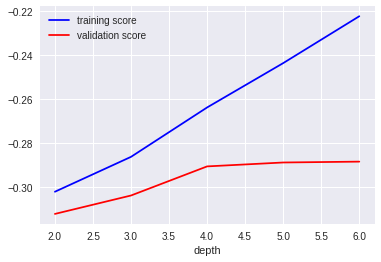

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

model = RandomForestRegressor(n_estimators=100)

depth = [2, 3, 4, 5, 6]
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True, return_estimator=True)

pd.DataFrame(scores)

,estimator,fit_time,score_time,test_score,train_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.033307,0.001375,-0.337244,-0.301801
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.001874,0.000781,-0.328457,-0.311336
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.001564,0.000746,-0.310722,-0.345121


In [22]:
scores['train_score'].mean(), scores['test_score'].mean()

(-0.31941926546138505, -0.3254743570077681)